In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [83]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url

In [84]:
dataset_url = 'https://files.fast.ai/data/examples/cifar10.tgz'
download_url(dataset_url,'.')

Using downloaded and verified file: .\cifar10.tgz


In [85]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Check Inside the data directory

In [86]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))

classes = os.listdir(data_dir +'/train')
print(classes)

['labels.txt', 'test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [87]:
airplane_file = os.listdir(data_dir + '/train/airplane')
print('No. of training examples for airplanes: ',len(airplane_file))
print(airplane_file[:5])

No. of training examples for airplanes:  5000
['10008_airplane.png', '10010_airplane.png', '10020_airplane.png', '10024_airplane.png', '10031_airplane.png']


In [88]:
ship_test_file = os.listdir(data_dir + '/train/ship')
print('No. of training examples for Shipes: ',len(ship_test_file))
print(ship_test_file[:5])

No. of training examples for Shipes:  5000
['10003_ship.png', '10004_ship.png', '10016_ship.png', '10042_ship.png', '10065_ship.png']


In [89]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [90]:
dataset = ImageFolder(data_dir+'/train', transform = ToTensor())

In [91]:
img, label = dataset[10]
print(img.shape, label)


torch.Size([3, 32, 32]) 0


In [92]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [93]:
def show(img, label):
    
    print('label', dataset.classes[label], '('+str(label)+')')
    plt.imshow(img.permute(1,2,0))

label bird (2)


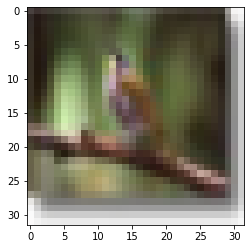

In [94]:
show(*dataset[11111])

In [95]:
def split_indics(n, val_pct = 0.1, seed = 99):
    
    n_val = int(val_pct *n)
    
    np.random.seed(seed)
    
    indxs = np.random.permutation(n)
    
    return indxs[n_val:],indxs[:n_val]

In [96]:
val_pct =0.2
rand_seed = 42

train_indics, val_indics , = split_indics(len(dataset), val_pct, rand_seed)

print(len(train_indics))
print('Sample Validation Indics :', val_indics[:10])

40000
Sample Validation Indics : [33553  9427   199 12447 39489 42724 10822 49498  4144 36958]


In [97]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [98]:
batch_size= 120

train_sampler = SubsetRandomSampler(train_indics)
train_dl = DataLoader(dataset, batch_size, sampler = train_sampler)

valid_sampler = SubsetRandomSampler(val_indics)
vaild_dl = DataLoader(dataset, batch_size, sampler = valid_sampler)

In [99]:
from torchvision.utils import make_grid

def show_batch(dl):
    
    for image, label in dl:
        
        fig, ax = plt.subplots(figsize = (10,10))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(image,10).permute(1,2,0))
        break

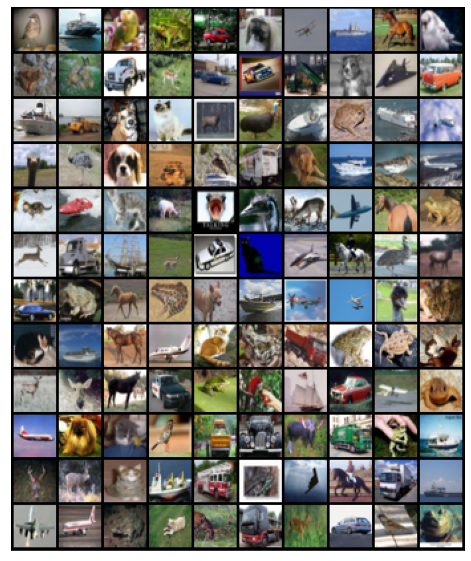

In [100]:
show_batch(train_dl)

In [101]:
import torch.nn as nn
import torch.nn.functional as F

In [102]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8,kernel_size = 3,stride =1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [127]:
?nn.Conv2d

In [104]:
for image, label in train_dl:
    
    print(image.shape)
    
    out = simple_model(image)
    
    print(out.shape)
    break

torch.Size([120, 3, 32, 32])
torch.Size([120, 8, 16, 16])


In [105]:
model = nn.Sequential(
    nn.Conv2d(3,16, kernel_size =3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size =3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size =3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size =3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    nn.Conv2d(16,16, kernel_size =3, stride = 1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2,2),
    
    
    nn.Flatten(),
    nn.Linear(16,10)
    

)

In [106]:
model[0].weight.shape

torch.Size([16, 3, 3, 3])

In [107]:
for image, label in train_dl:
    
    print(image.shape)
    out = model(image)
    
    print(out.shape)
    print(out[0])
    break

torch.Size([120, 3, 32, 32])
torch.Size([120, 10])
tensor([ 0.2244,  0.1941, -0.0750,  0.1935, -0.2604,  0.0756, -0.1358,  0.1070,
        -0.0189, -0.2608], grad_fn=<SelectBackward>)


label cat (tensor(3))


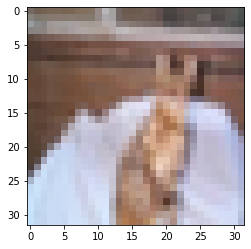

In [108]:
probs = F.softmax(out[0], dim=0)
#torch.sum(probs), probs

#print(dataset.classes[0])
#dataset.classes[label[0]]

show(image[0], label[0])

In [109]:
def loss_batch(model,loss_fn,xb,yb, opt = None, metric = None):
    
    output = model(xb)
    
    loss = loss_fn(output, yb)
    
    if opt is not None:
        
        loss.backward()
        
        opt.step()
        
        opt.zero_grad()
        
    metric_result = None
    
    if metric is not None:
        
        metric_result = metric (output, yb)
        
    return loss.item(), len(xb), metric_result

In [110]:
def evaluate(model, loss_fn, valid_ld, metric= None):
    
    with torch.no_grad():
        
        result = [loss_batch(model,loss_fn, xb, yb, metric = metric) for xb,yb in valid_ld]
        
        losses, num, metrics = zip(*result)
        
        total = np.sum(num)
        
        avg_loss = np.sum(np.multiply(num, losses))/ total
        
        avg_metric = None
        
        if metric is not None:
            
            avg_metric = np.sum(np.multiply(num, metrics))/ total
            
    return avg_loss, total, avg_metric
    

In [111]:
def fit(epochs, model,loss_fn, train_dl, valid_dl,opt_fn= None,lr=None ,metric = None):
    
    
    train_losses, val_losses , val_metrics =[],[],[]
    if opt_fn is None:
        
        opt_fn = torch.optim.SGD
        
    opt = opt_fn(model.parameters(), lr=lr)
    
    
    for epoch in range(epochs) :
        
        
        model.train()
        for xb,yb in train_dl:
            
            train_loss,_,_=loss_batch(model,loss_fn,xb,yb,opt)
        
        
        model.eval()
        result = evaluate(model,loss_fn,valid_dl, metric)
        
        val_loss, total, val_metric = result
        
       
        if metric is None:
            
            print('Epoch : [{}/{}]  , loss: {:.4f}'.format(epoch+1, epochs, val_loss))
            
        else:
            
            print(epoch+1, epochs, val_loss, val_metric)
            
    return train_loss, val_loss, val_metrics
            
            
   

In [112]:
def accuracy(output, label):
    
    _,pred = torch.max(output,dim=1)
    
    return torch.sum(pred== label).item()/ len(pred)

In [113]:
val_loss, _,val_acc = evaluate(model,F.cross_entropy, vaild_dl, metric = accuracy)

print('LOSS : {:.4f}, accuracy:  {:.4f}'.format(val_loss,val_acc))

LOSS : 2.3159, accuracy:  0.1009


In [115]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr=0.005

In [116]:
history = fit(num_epochs, model,F.cross_entropy,train_dl,vaild_dl,opt_fn,lr, accuracy)

train_loss,val_loss,val_metrics = history

1 10 1.5848051300048829 0.405
2 10 1.437626639842987 0.4788
3 10 1.3287623362541199 0.5145
4 10 1.298652060031891 0.5345
5 10 1.337673099040985 0.516
6 10 1.2348595085144043 0.5508
7 10 1.1670210390090943 0.5768
8 10 1.159039964914322 0.5751
9 10 1.1300337057113647 0.5914
10 10 1.136008252620697 0.5981


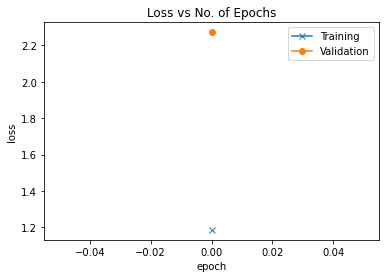

In [120]:
def plot_loss(train_loss, val_loss):
    
    plt.plot(train_loss,'-x')
    plt.plot(val_loss,'-o')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs No. of Epochs')
    
    
plot_loss(+train_loss,[val_loss]+val_loss)

In [121]:
def predict_img(img, model):
    
    xb = img.unsqueeze(0)
    
    yb = model(xb)
    _,preds = torch.max(yb, dim=1)
    
    return dataset.classes[preds[0].item()]

In [124]:
test_dataset = ImageFolder(data_dir+'/test', transform = ToTensor())

label airplane predicited  ship


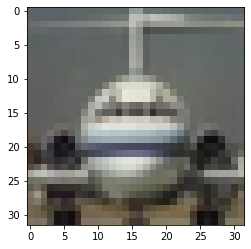

In [125]:
img,label = test_dataset[10]
plt.imshow(img.permute(1,2,0))
print('label', dataset.classes[label], 'predicited ', predict_img(img,model))

In [126]:
test_loader = DataLoader(test_dataset, batch_size)

test_loss,_, test_acc = evaluate(model,F.cross_entropy, test_loader, metric = accuracy)

print(test_loss, test_acc)

1.1532191705703736 0.5873
